<a href="https://www.kaggle.com/code/archismancoder/binarypredpoisonousmushrooms-lgbm-xgb-catb-ensemb?scriptVersionId=191250945" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv

/kaggle/input/playground-series-s4e8/train.csv

/kaggle/input/playground-series-s4e8/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 3116945 entries, 0 to 3116944

Data columns (total 22 columns):

 #   Column                Dtype  

---  ------                -----  

 0   id                    int64  

 1   class                 object 

 2   cap-diameter          float64

 3   cap-shape             object 

 4   cap-surface           object 

 5   cap-color             object 

 6   does-bruise-or-bleed  object 

 7   gill-attachment       object 

 8   gill-spacing          object 

 9   gill-color            object 

 10  stem-height           float64

 11  stem-width            float64

 12  stem-root             object 

 13  stem-surface          object 

 14  stem-color            object 

 15  veil-type             object 

 16  veil-color            object 

 17  has-ring              object 

 18  ring-type             object 

 19  spore-print-color     object 

 20  habitat               object 

 21  season                object 

dtypes: float64(3), 

In [4]:
df_train.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

In [5]:
df_train.duplicated().sum()

0

## Memory Optimization

In [6]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


#### Memory Optimization for Training & Validation Dataset

In [7]:
# df_train = reduce_memory_usage(df_train)
# df_test = reduce_memory_usage(df_test)

In [8]:
df_train.shape

(3116945, 22)

## DATA VISUALIZATION

### %-age of missing values

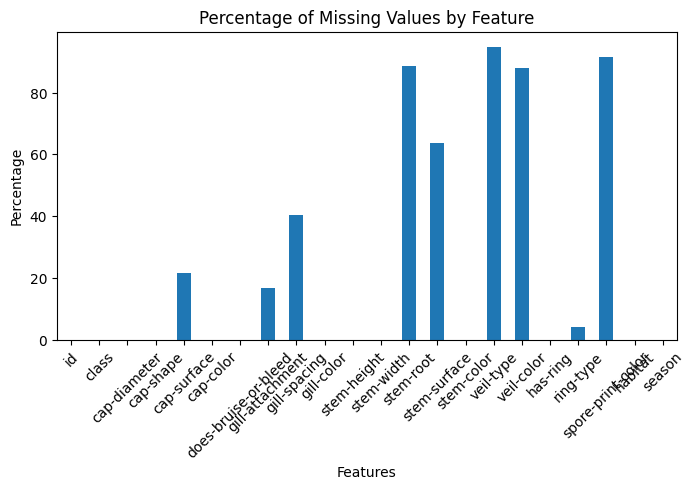

In [9]:
import matplotlib.pyplot as plt

missing_values = df_train.isnull().mean() * 100

# Plot
missing_values.plot(kind='bar', figsize=(8, 4))

plt.title('Percentage of Missing Values by Feature')
plt.ylabel('Percentage')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

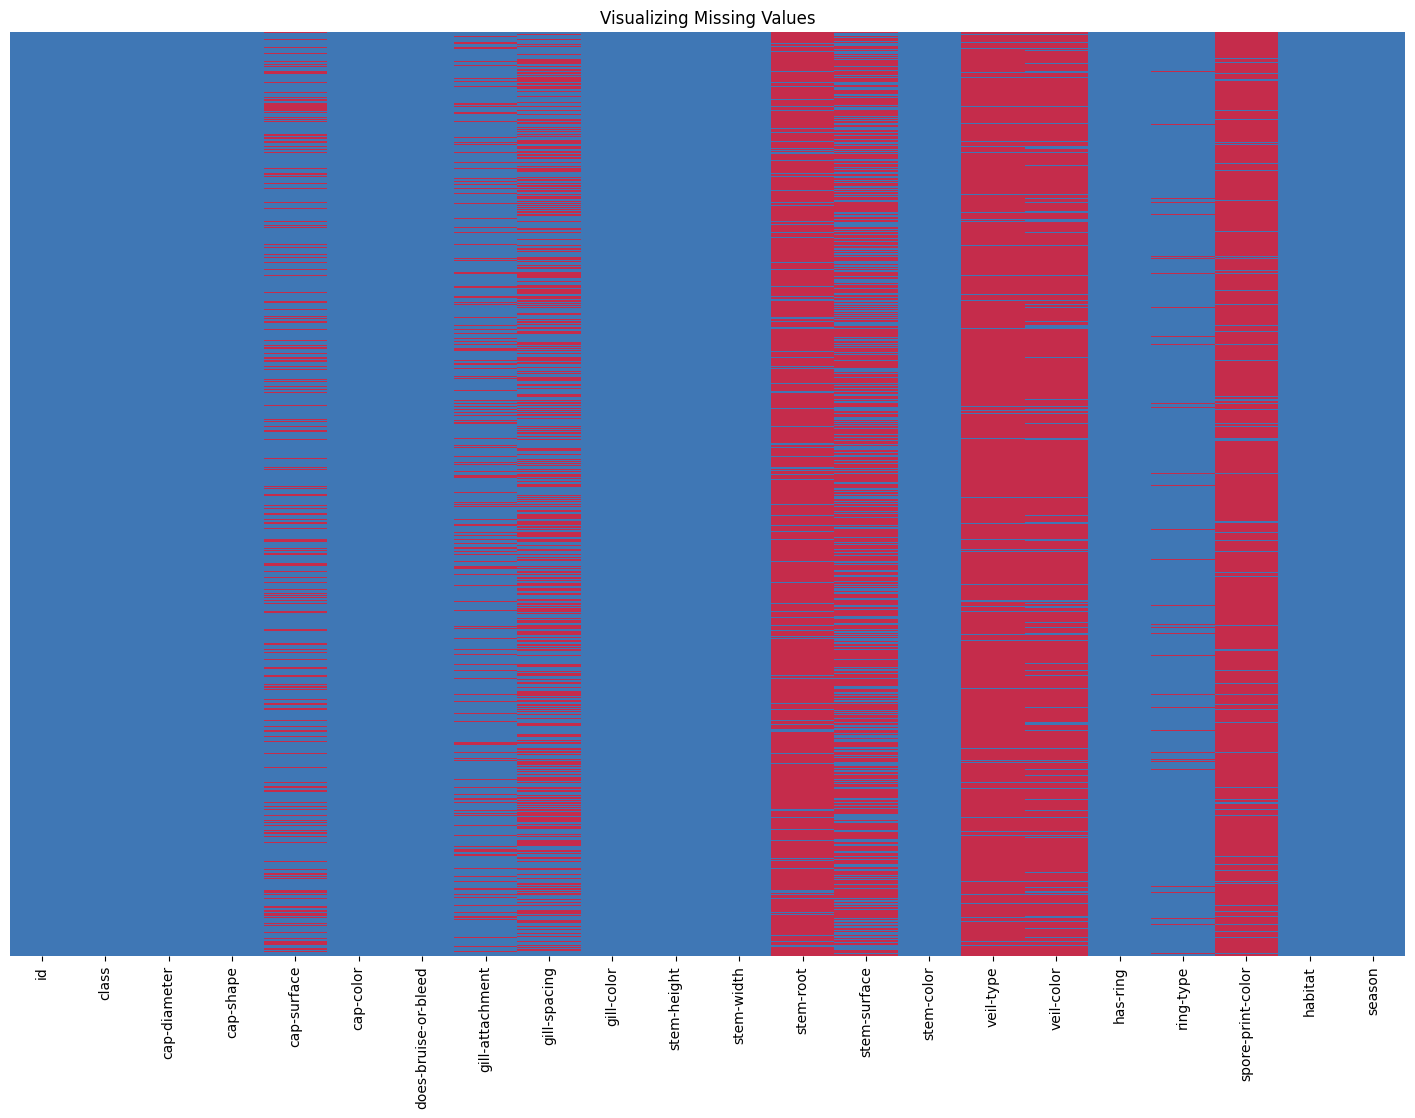

In [10]:
import seaborn as sns

plt.figure(figsize=(18,12))
plt.title("Visualizing Missing Values")
sns.heatmap(df_train.isnull(), cbar=False, cmap=sns.color_palette("Spectral_r", n_colors=13), yticklabels=False);

## FEATURE EXPLORATION

In [11]:
categorical_cols = [col for col in df_train.columns if df_train[col].dtype == 'category' and col != 'class']
continuous_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float16']
FEATURES = [col for col in df_train.columns if col not in ['id', 'class']]
TARGET = 'class'

In [12]:
# sns.set_style('darkgrid')

def categorical_distributions_plot(df, cols, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 32))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        temp = df[col].value_counts().nlargest(10).reset_index()
        temp.columns = [col, 'count']
        sns.barplot(y=col, x='count', data=temp, palette='Set2', ax=ax, order=temp[col])
        
        ax.set_xlabel('Count', fontsize=12)
        ax.set_ylabel(col, fontsize=12)
        ax.set_title(f'Distribution of {col}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=10)
    
    fig.tight_layout()
    plt.show()


In [13]:
categorical_distributions_plot(df_train, categorical_cols)

<Figure size 1600x3200 with 0 Axes>

In [14]:
def categorical_vs_target_plot(df, cols, target, rows_num=6, cols_num=3):
    fig = plt.figure(figsize=(16, 14))
    
    for idx, col in enumerate(cols):
        ax = fig.add_subplot(rows_num, cols_num, idx + 1)
        target_distribution = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)
        top_categories = df[col].value_counts().nlargest(10).index
        target_distribution = target_distribution.loc[top_categories]
        target_distribution = target_distribution.sort_values(by=target_distribution.columns.tolist(), ascending=False)
        target_distribution.plot(kind='bar', stacked=True, colormap='Set2', edgecolor='black', alpha=0.7, ax=ax)
        
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Proportion', fontsize=12)
        ax.set_title(f'{col} and {target}', fontsize=14)
        ax.xaxis.set_tick_params(rotation=45)
        ax.yaxis.set_tick_params(rotation=0)
        ax.legend(title=target, fontsize=10)
    
    fig.tight_layout()
    plt.show()

In [15]:
categorical_vs_target_plot(df_train, categorical_cols, 'class')

<Figure size 1600x1400 with 0 Axes>

## PREPROCESSING

In [16]:
df_train.drop(['id'], axis = 1, inplace = True)
df_test.drop(['id'], axis = 1, inplace = True)

#### Mapping p:1 and e:0

In [17]:
df_train['class'] = df_train['class'].map({'p': 1, 'e': 0})

#### Converting categorical features to strings

In [18]:
for col in categorical_cols:
    if col in FEATURES:
        df_train[col] = df_train[col].astype(str).fillna('NaN')
        df_test[col] = df_test[col].astype(str).fillna('NaN')

In [19]:
df_train[FEATURES].head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [20]:
df_train

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,0,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,0,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,0,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,0,9.29,f,NaN,n,t,NaN,NaN,w,12.14,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,0,10.88,s,NaN,w,t,d,c,p,6.65,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,1,7.82,x,e,e,f,a,NaN,w,9.51,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,0,9.45,p,i,n,t,e,NaN,p,9.13,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


# MODELS

In [21]:
import missingno as msno
from sklearn import set_config
from sklearn.base import clone
import matplotlib.pyplot as plt
import warnings

In [22]:
#preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder

#statistics
from scipy.stats import randint, mode

#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline


#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV

#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, matthews_corrcoef, make_scorer


#for algorithm run time comparison
import time

#define a random_state for reproducibility
random_state = 42

In [23]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col=[0])

train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [24]:
# train = reduce_memory_usage(df_train)

In [25]:
# test = reduce_memory_usage(df_test)

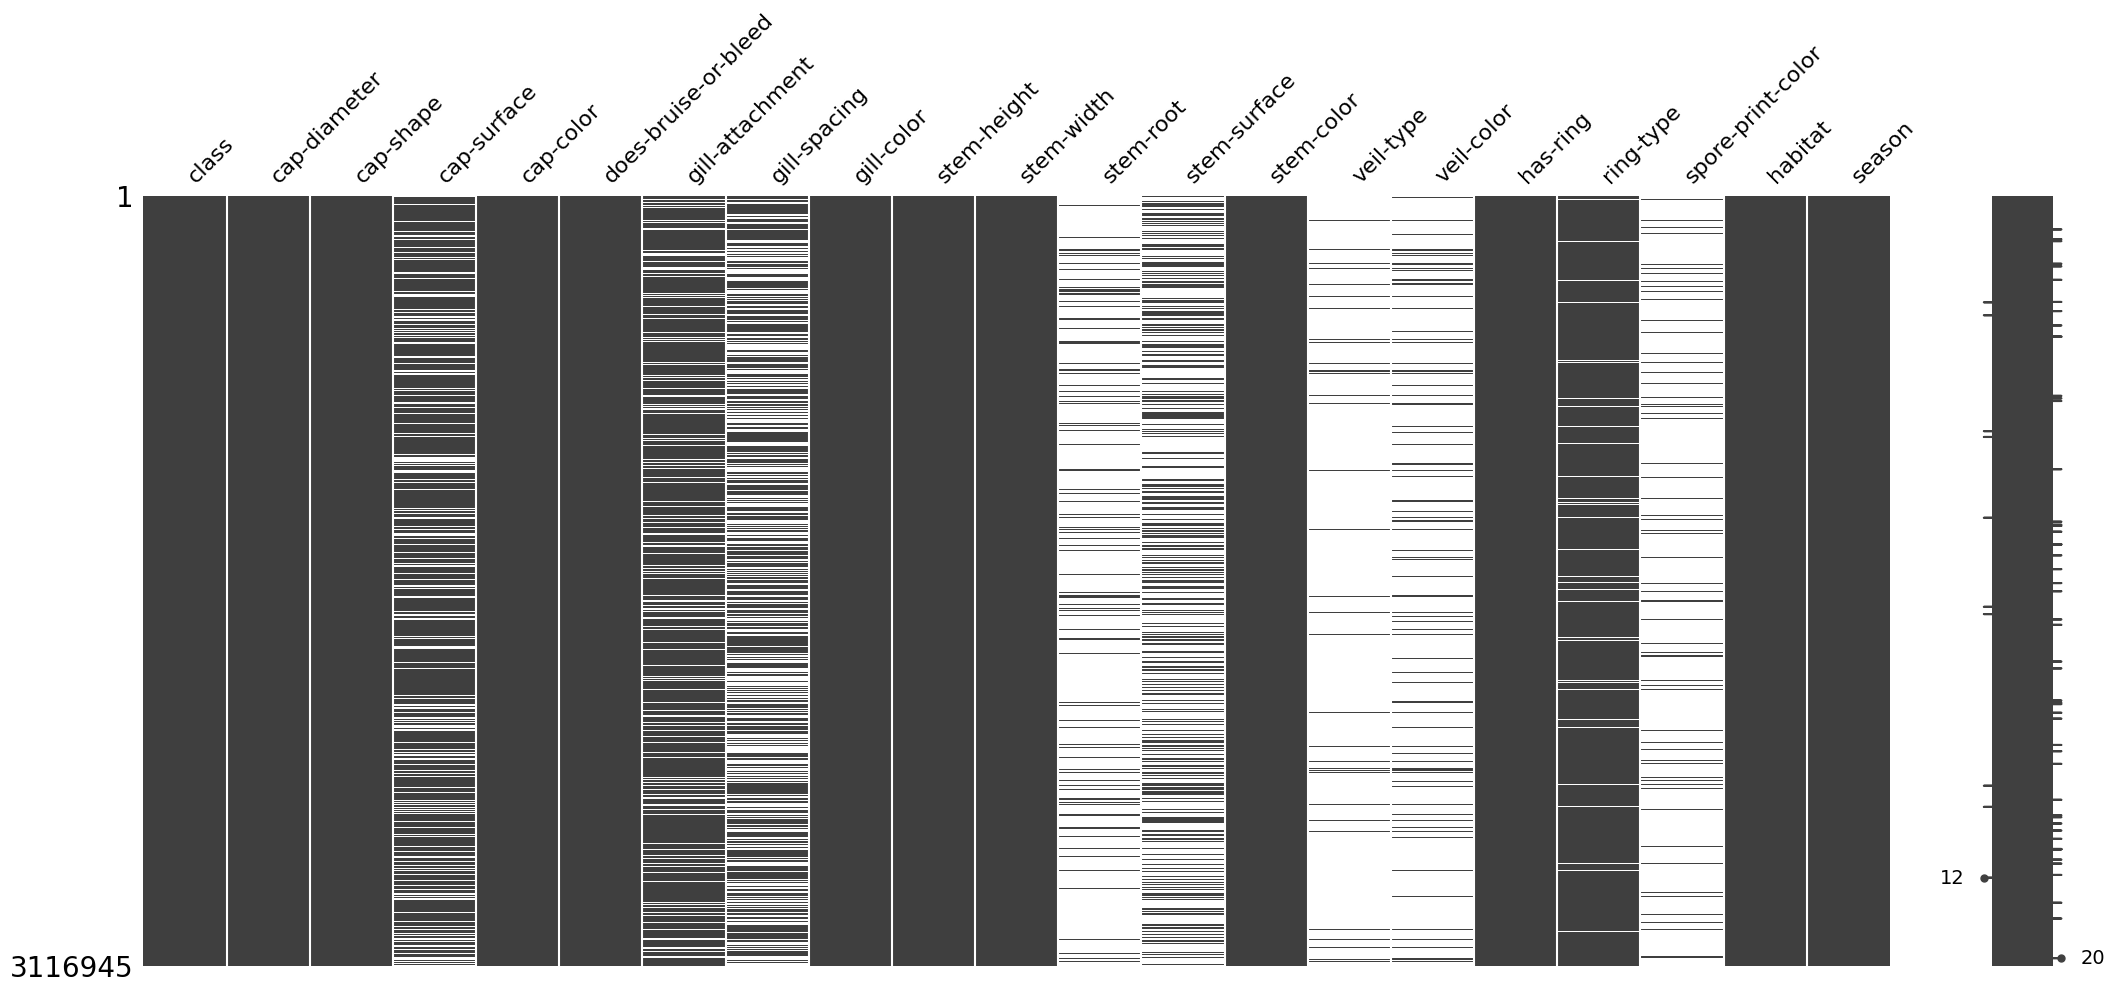

In [26]:
msno.matrix(train_df)
plt.show()

In [27]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing!=0).any(axis=1)]
missing["missing_percent"] = missing[0:] / len(train_df) *100
missing.style.background_gradient('viridis')

,missing_count,missing_percent
veil-type,2957493,94.884350
spore-print-color,2849682,91.425482
stem-root,2757023,88.452732
veil-color,2740947,87.936970
stem-surface,1980861,63.551362
gill-spacing,1258435,40.373988
cap-surface,671023,21.528227
gill-attachment,523936,16.809280
ring-type,128880,4.134818
gill-color,57,0.001829


In [28]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.90


<Axes: ylabel='class'>

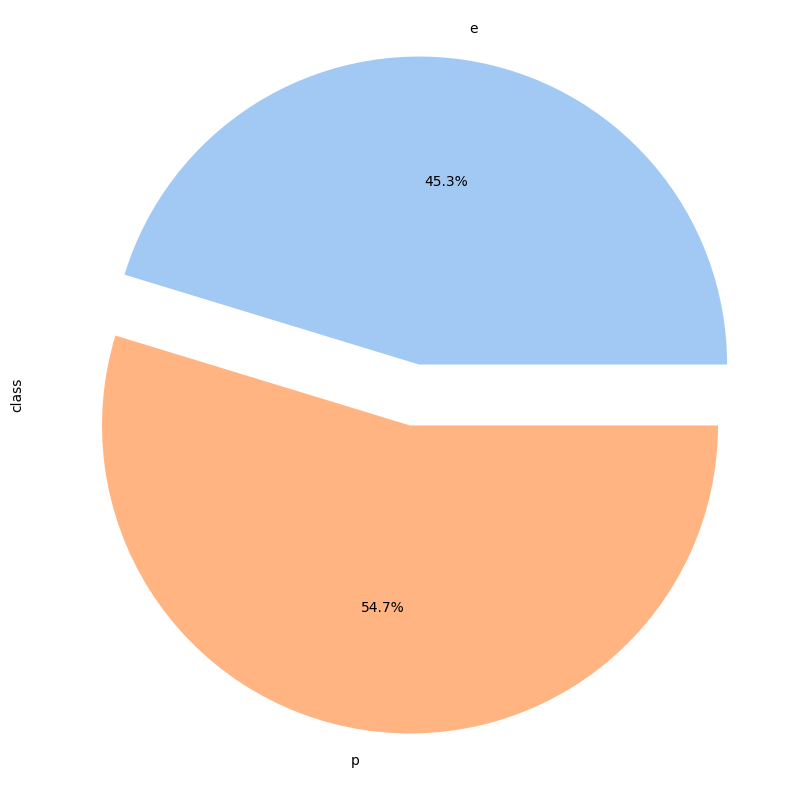

In [29]:
import seaborn as sns
plt.figure(figsize=(10,10))
palette_color = sns.color_palette('pastel')
explode = [0.1, 0.1]
train_df.groupby('class')['class'].count().plot.pie(colors=palette_color,explode=explode, autopct="%1.1f%%")

In [30]:
# train_df = df_train
# test_df = df_train

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

Index: 3116945 entries, 0 to 3116944

Data columns (total 21 columns):

 #   Column                Dtype  

---  ------                -----  

 0   class                 object 

 1   cap-diameter          float64

 2   cap-shape             object 

 3   cap-surface           object 

 4   cap-color             object 

 5   does-bruise-or-bleed  object 

 6   gill-attachment       object 

 7   gill-spacing          object 

 8   gill-color            object 

 9   stem-height           float64

 10  stem-width            float64

 11  stem-root             object 

 12  stem-surface          object 

 13  stem-color            object 

 14  veil-type             object 

 15  veil-color            object 

 16  has-ring              object 

 17  ring-type             object 

 18  spore-print-color     object 

 19  habitat               object 

 20  season                object 

dtypes: float64(3), object(18)

memory usage: 523.2+ MB


In [32]:
le = LabelEncoder()

train_df['class'] = le.fit_transform(train_df['class'])

### Grouping features for preprocessing purposes

In [33]:
feature_list = [feature for feature in train_df.columns if not feature  == "class"]

target = "class"

numerical_features = ['stem-height', 'cap-diameter', 'stem-width']

categorical_features = list(set(feature_list) - set(numerical_features))

assert feature_list.sort() == (numerical_features + categorical_features).sort()

In [34]:
eda_df = train_df.sample(frac= 0.1, random_state=random_state)

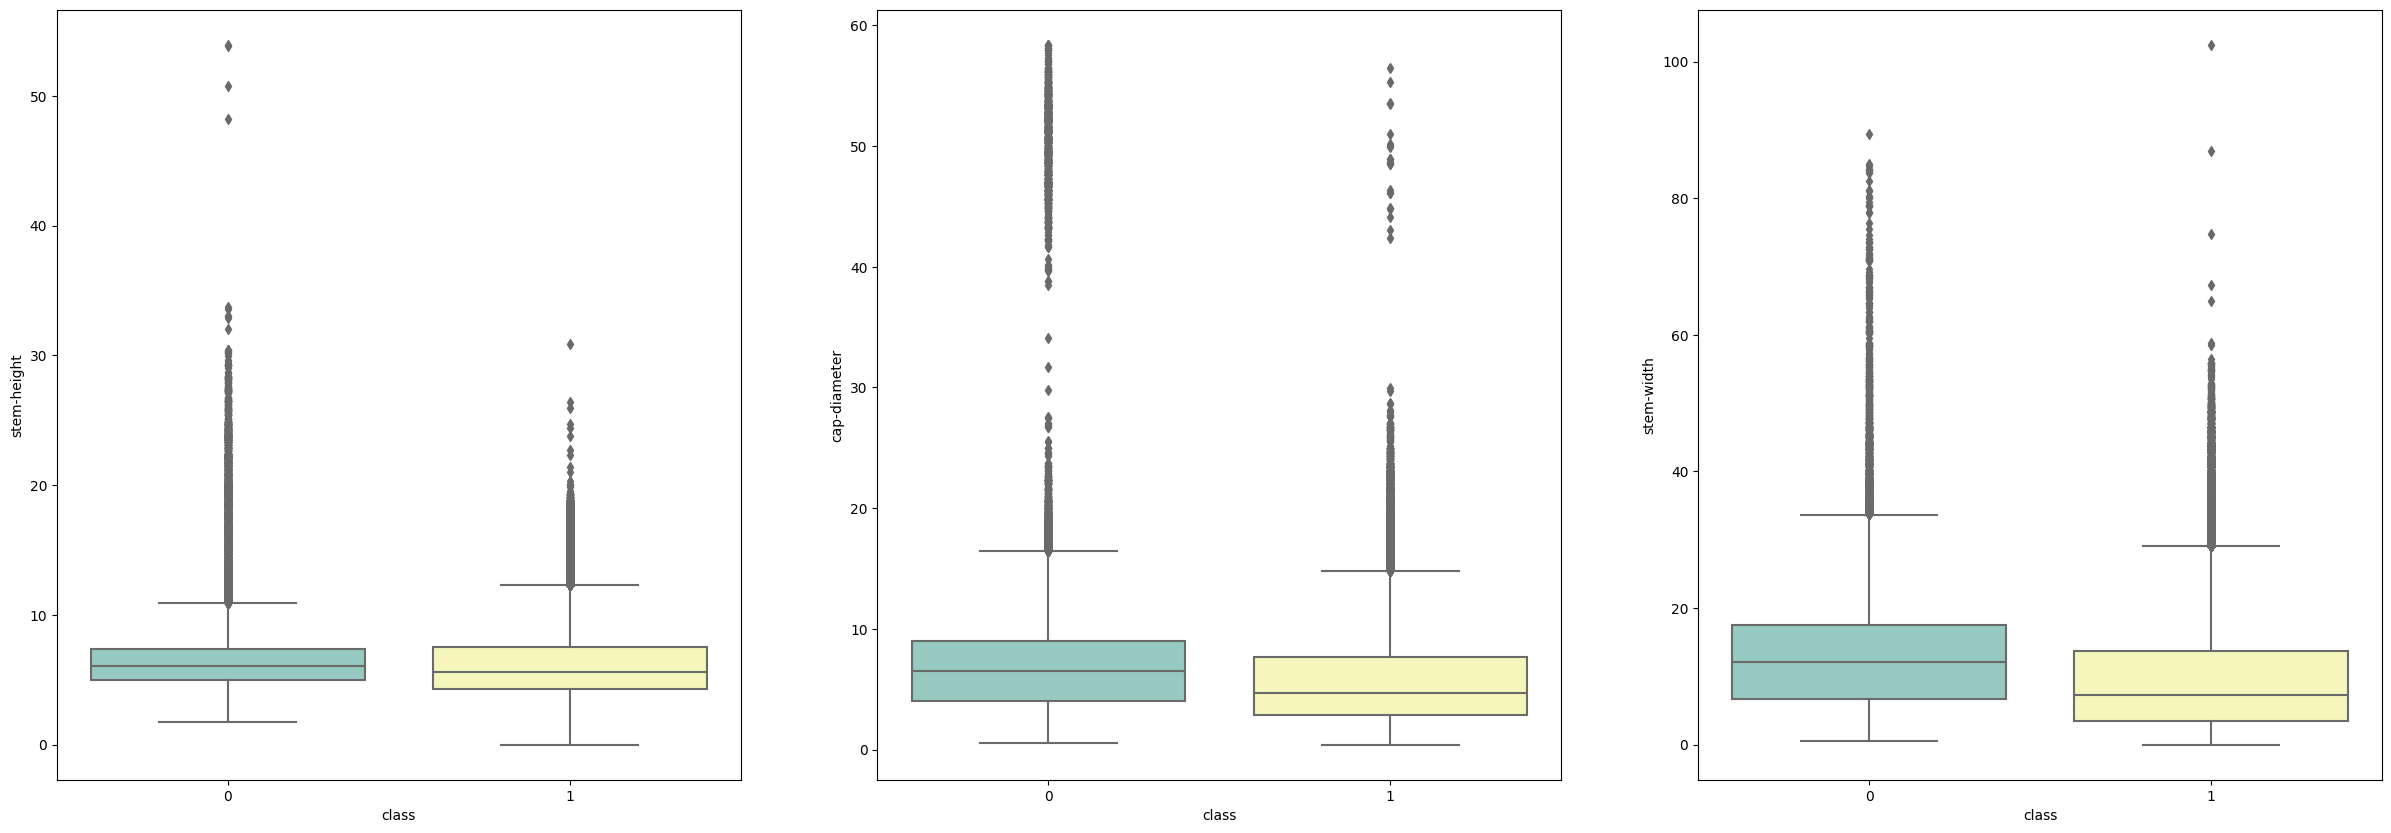

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(x='class', y=var, data=eda_df, ax=subplot, palette='Set3')

##### Checking for cardinality

In [36]:
train_df[categorical_features].nunique().sort_values()

season                   4
veil-type               22
has-ring                23
veil-color              24
does-bruise-or-bleed    26
spore-print-color       32
stem-root               38
ring-type               40
gill-spacing            48
habitat                 52
stem-color              59
stem-surface            60
gill-color              63
cap-shape               74
cap-color               78
gill-attachment         78
cap-surface             83
dtype: int64

#### Categoricals
#### Just visualize moderate cardinality features

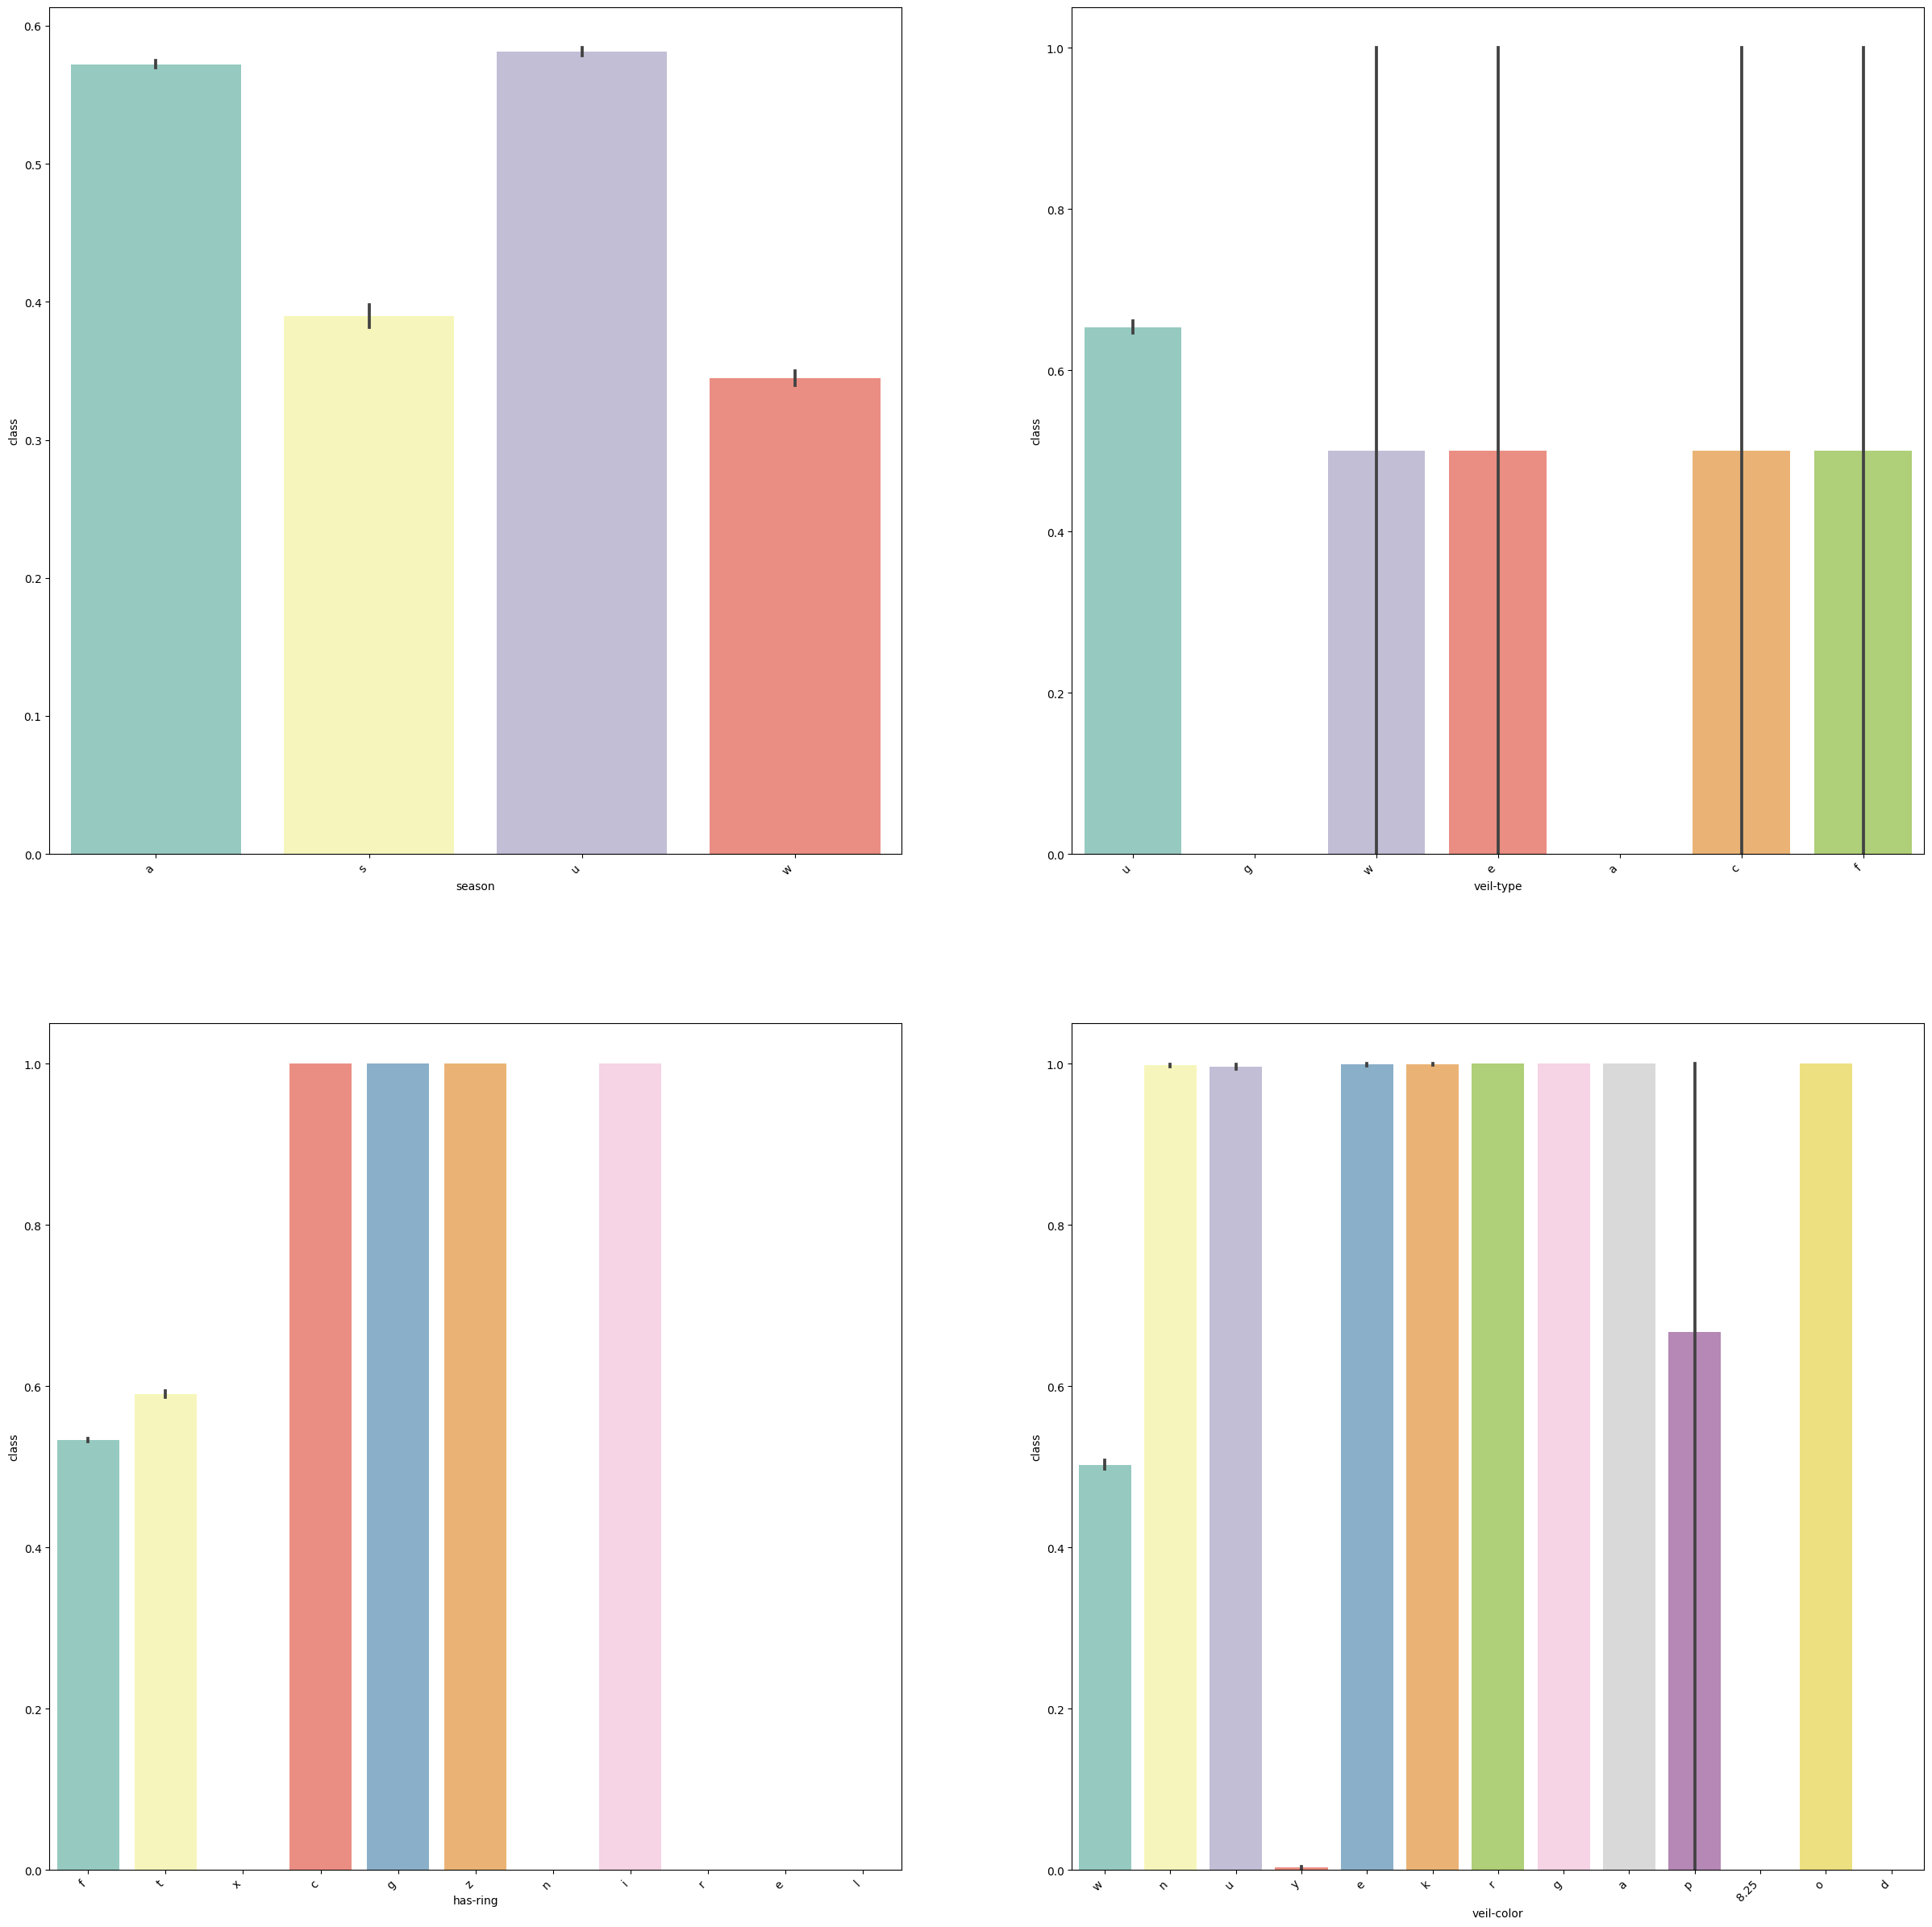

In [37]:

moderate_cardinality_features = ['season', 'veil-type', 'has-ring', 'veil-color']

fig, ax = plt.subplots(2, 2, figsize=(30, 30))
for var, subplot in zip(moderate_cardinality_features, ax.flatten()):
    sns.barplot(x=var,y= 'class',  data=eda_df, ax=subplot, palette='Set3')
    subplot.set_xticklabels(subplot.get_xticklabels(), rotation=45, ha='right')

#### Mutual Information score

In [38]:
y_sampled = eda_df['class']
mutual_df = eda_df[numerical_features]

mutual_info = mutual_info_classif(mutual_df.fillna(0), y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
stem-width,0.067187
cap-diameter,0.043046
stem-height,0.039790


In [39]:
mutual_df_categorical = eda_df[categorical_features]
#categorical features must be encoded to get mutual information
for colname in mutual_df_categorical:
    mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()
mutual_info = mutual_info_classif(mutual_df_categorical.fillna("Do_not_have_feature"), y_sampled, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_Feature_MI"] ).style.background_gradient("cool")

/tmp/ipykernel_24/1847787907.py:4: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()

/tmp/ipykernel_24/1847787907.py:4: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mutual_df_categorical[colname], _ = mutual_df_categorical[colname].factorize()

/tmp/ipykernel_24/1847787907.py:4: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value ins

,Categorical_Feature_MI
stem-root,0.052458
veil-color,0.049626
spore-print-color,0.047357
veil-type,0.038808
does-bruise-or-bleed,0.032546
gill-color,0.026048
ring-type,0.024119
cap-color,0.021974
stem-color,0.018512
cap-shape,0.016815


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

  data_subset = grouped_data.get_group(pd_key)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tup

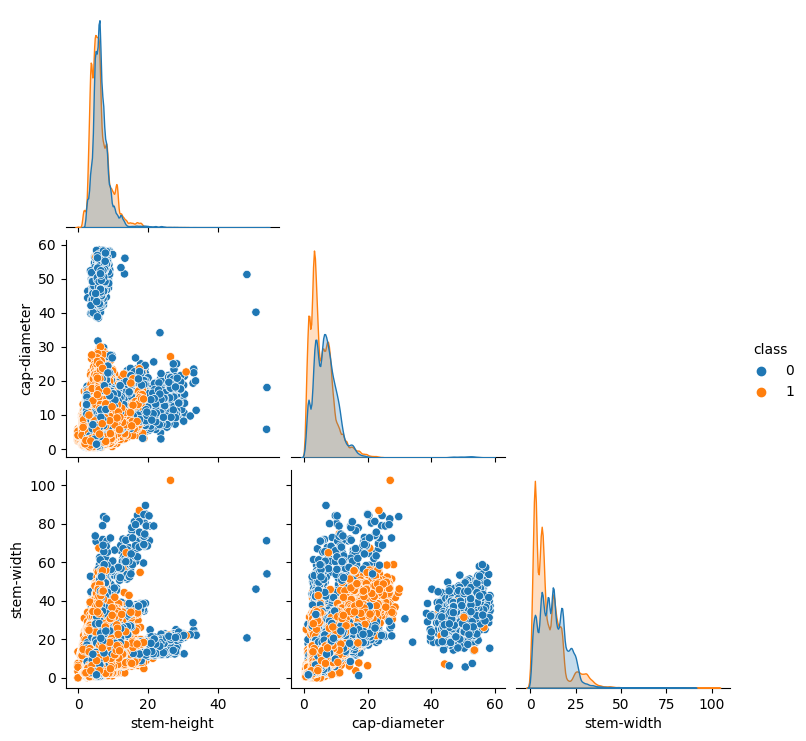

In [40]:
sns.pairplot(eda_df[numerical_features + ["class"]], hue="class",  corner=True)

## Preprocessing for CatBoost, LGBM, XGB

In [41]:
train_df[categorical_features] = train_df[categorical_features].astype('category')
test_df[categorical_features] = test_df[categorical_features].astype('category')

In [42]:
def preprocess_catboost(train_df, test_data, cat_features):
    for col in cat_features:
        train_df[col] = train_df[col].astype(str).fillna('NaN')
        test_data[col] = test_data[col].astype(str).fillna('NaN')
    return train_df, test_data

#### For XGB

In [43]:
encoder  = ColumnTransformer(remainder='passthrough',
    transformers=[
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features),
    ])

encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['stem-surface', 'ring-type',
                                  'does-bruise-or-bleed', 'habitat',
                                  'gill-attachment', 'veil-type',
                                  'gill-spacing', 'season', 'cap-color',
                                  'cap-shape', 'cap-surface',
                                  'spore-print-color', 'veil-color', 'has-ring',
                                  'stem-color', 'gill-color', 'stem-root'])])

### MODELLING

In [44]:
y = train_df['class']
train_df = train_df.drop(['class'], axis=1)

In [45]:
#CV strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

In [46]:
def cross_validate_score(model, train_df, y, cv, test_data):
    val_scores = []
    test_preds = np.zeros((test_data.shape[0],))
    oof_preds = np.zeros((train_df.shape[0],))

    if isinstance(model, CatBoostClassifier):
        cat_features = model.get_params().get('cat_features', [])
        train_df, test_data = preprocess_catboost(train_df, test_data, cat_features)

    for fold, (train_idx, val_idx) in enumerate(cv.split(train_df, y)):
        X_train = train_df.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        X_val = train_df.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        model = clone(model)

        eval_set = [(X_val, y_val)]

        if isinstance(model, LGBMClassifier):
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                callbacks=[early_stopping(50), log_evaluation(1000)],
            )
        elif isinstance(model, CatBoostClassifier):
            model.fit(
                X_train, y_train,
                eval_set=eval_set,
                early_stopping_rounds=50,
                verbose=1000
            )

        else:
            model.fit(
                X_train, y_train,

            )
        
        val_probs = model.predict_proba(X_val)[:, 1]  # Get the probabilities
        val_preds = (val_probs > 0.5).astype(int)     # Convert probabilities to class labels for MCC

        val_score = matthews_corrcoef(y_val, val_preds)  # Calculate MCC
        print(f'Fold {fold}: MCC = {val_score:.5f}')
        
        val_scores.append(val_score)
        
        oof_preds[val_idx] = val_probs  # Store the probabilities for OOF predictions

        test_preds += model.predict_proba(test_data)[:, 1] / cv.get_n_splits()  # Aggregate test probabilities

    mean_val_score = np.mean(val_scores)
    std_val_score = np.std(val_scores)
    print(f'Mean Validation MCC: {mean_val_score:.7f}')
    print(f'Std Validation MCC: {std_val_score:.7f}')
    
    return val_scores, test_preds, oof_preds

In [47]:
cv_summary, test_preds, oof_preds = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### XGBoost

In [48]:
xgb_optuna_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'tree_method': 'gpu_hist',
    'alpha': 0.008818603899257224,
    'subsample': 0.8942559527111149,
    'colsample_bytree': 0.38691151988228056,
    'max_depth': 12,
    'min_child_weight': 7,
    'gamma': 0.07694184062646398
}



xgb_tuned = XGBClassifier(**xgb_optuna_params, random_state=random_state)


xgb_pipeline = make_pipeline(encoder, xgb_tuned)
xgb_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['stem-surface', 'ring-type',
                                                   'does-bruise-or-bleed',
                                                   'habitat', 'gill-attachment',
                                                   'veil-type', 'gill-spacing',
                                                   'season', 'cap-color',
                                                   'cap-shape', 'cap-surface',
                                                   'spore-print-color',
                                                   'veil...
                               feature_types=None, gamma=0.07694184062646398,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=None,
                               min_child_weight=7, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [49]:
%%time
cv_summary['xgb'], test_preds['xgb'], oof_preds['xgb'] = cross_validate_score(xgb_pipeline, train_df , y,  cv, test_df)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:33:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:34:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:34:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is

Fold 0: MCC = 0.98473


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:36:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)


Fold 1: MCC = 0.98471


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:37:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:38:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)


Fold 2: MCC = 0.98483


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:39:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)


Fold 3: MCC = 0.98459


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:41:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.



    E.g. tree_method = "hist", device = "cuda"



  warnings.warn(smsg, UserWarning)


Fold 4: MCC = 0.98476

Mean Validation MCC: 0.9847262

Std Validation MCC: 0.0000771

CPU times: user 9min 32s, sys: 9.14 s, total: 9min 41s

Wall time: 9min 2s


### LightGBM

In [50]:
lgbm_optuna_params = {
    'n_estimators': 10000,
    'learning_rate': 0.02,
    "categorical_feature" : categorical_features,
    'device': 'gpu',
    'max_depth': 10,
    'min_data_in_leaf': 85,
    'subsample': 0.6720606456166781,
    'max_bin': 240,
    'feature_fraction': 0.6946327643448142,

}



lgbm_tuned = LGBMClassifier(**lgbm_optuna_params, random_state=random_state, verbose=-1)

In [51]:
%%time
cv_summary['lgbm'], test_preds['lgbm'], oof_preds['lgbm'] = cross_validate_score(lgbm_tuned, train_df , y,  cv, test_df)

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.

1 warning generated.


Training until validation scores don't improve for 50 rounds

[1000]	valid_0's binary_logloss: 0.0386003

[2000]	valid_0's binary_logloss: 0.0370253

[3000]	valid_0's binary_logloss: 0.0365087

[4000]	valid_0's binary_logloss: 0.0363331

[5000]	valid_0's binary_logloss: 0.0362539

Early stopping, best iteration is:

[5360]	valid_0's binary_logloss: 0.036242

Fold 0: MCC = 0.98456


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias

Training until validation scores don't improve for 50 rounds

[1000]	valid_0's binary_logloss: 0.038588

[2000]	valid_0's binary_logloss: 0.0368933

[3000]	valid_0's binary_logloss: 0.0364528

[4000]	valid_0's binary_logloss: 0.0362698

[5000]	valid_0's binary_logloss: 0.0361891

Early stopping, best iteration is:

[5908]	valid_0's binary_logloss: 0.0361578

Fold 1: MCC = 0.98459


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias

Training until validation scores don't improve for 50 rounds

[1000]	valid_0's binary_logloss: 0.0386948

[2000]	valid_0's binary_logloss: 0.0369297

[3000]	valid_0's binary_logloss: 0.0364862

[4000]	valid_0's binary_logloss: 0.0363395

Early stopping, best iteration is:

[4495]	valid_0's binary_logloss: 0.0362912

Fold 2: MCC = 0.98454


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias

Training until validation scores don't improve for 50 rounds

[1000]	valid_0's binary_logloss: 0.0386764

[2000]	valid_0's binary_logloss: 0.0371029

[3000]	valid_0's binary_logloss: 0.0367118

[4000]	valid_0's binary_logloss: 0.0365505

[5000]	valid_0's binary_logloss: 0.0364804

Early stopping, best iteration is:

[5025]	valid_0's binary_logloss: 0.0364792

Fold 3: MCC = 0.98442


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias} in param dict is overridden.')

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2034: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.

Please use categorical_feature argument of the Dataset constructor to pass this parameter.

  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2054: UserWarning: categorical_feature in param dict is overridden.

  _log_warning(f'{cat_alias

Training until validation scores don't improve for 50 rounds

[1000]	valid_0's binary_logloss: 0.0385109

[2000]	valid_0's binary_logloss: 0.0369425

[3000]	valid_0's binary_logloss: 0.0365613

Early stopping, best iteration is:

[3630]	valid_0's binary_logloss: 0.0364525

Fold 4: MCC = 0.98441

Mean Validation MCC: 0.9845042

Std Validation MCC: 0.0000743

CPU times: user 3h 55min 12s, sys: 48.2 s, total: 3h 56min

Wall time: 1h 56min 42s


### CatBoost

In [52]:
#Parameters found tuning process by Optuna
catb_params = {    
    "n_estimators" : 10000,
    "learning_rate" : 0.075,
    'cat_features' : categorical_features,
    'task_type': 'GPU',
    'random_strength': 0.3718364180573207,
    'max_bin': 128,
    'depth': 9,
    'l2_leaf_reg': 6,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.41936688658110405
}

# Catb with found hyperparameters
catb_tunned = CatBoostClassifier(**catb_params, random_state=random_state)

In [53]:
%%time
cv_summary['catb'], test_preds['catb'], oof_preds['catb'] = cross_validate_score(catb_tunned, train_df , y,  cv, test_df)

0:	learn: 0.6067452	test: 0.6065195	best: 0.6065195 (0)	total: 655ms	remaining: 1h 49m 8s

1000:	learn: 0.0353285	test: 0.0369256	best: 0.0369256 (1000)	total: 7m 56s	remaining: 1h 11m 23s

2000:	learn: 0.0333262	test: 0.0363208	best: 0.0363206 (1998)	total: 16m 53s	remaining: 1h 7m 29s

3000:	learn: 0.0318365	test: 0.0361578	best: 0.0361554 (2990)	total: 26m 12s	remaining: 1h 1m 7s

bestTest = 0.03612549833

bestIteration = 3356

Shrink model to first 3357 iterations.

Fold 0: MCC = 0.98456

0:	learn: 0.6063969	test: 0.6062841	best: 0.6062841 (0)	total: 564ms	remaining: 1h 34m

1000:	learn: 0.0352644	test: 0.0368694	best: 0.0368690 (999)	total: 8m	remaining: 1h 12m 3s

2000:	learn: 0.0333372	test: 0.0363135	best: 0.0363135 (1999)	total: 16m 55s	remaining: 1h 7m 39s

bestTest = 0.03615131801

bestIteration = 2794

Shrink model to first 2795 iterations.

Fold 1: MCC = 0.98452

0:	learn: 0.6037104	test: 0.6034023	best: 0.6034023 (0)	total: 614ms	remaining: 1h 42m 17s

1000:	learn: 0.0354

In [54]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold1,fold2,fold3,fold4,fold5,Mean,Std
xgb,0.984733,0.984711,0.984831,0.984595,0.984762,0.984726,0.000077
lgbm,0.984558,0.984595,0.984536,0.984424,0.984409,0.984504,0.000074
catb,0.984558,0.984520,0.984578,0.984216,0.984522,0.984479,0.000133


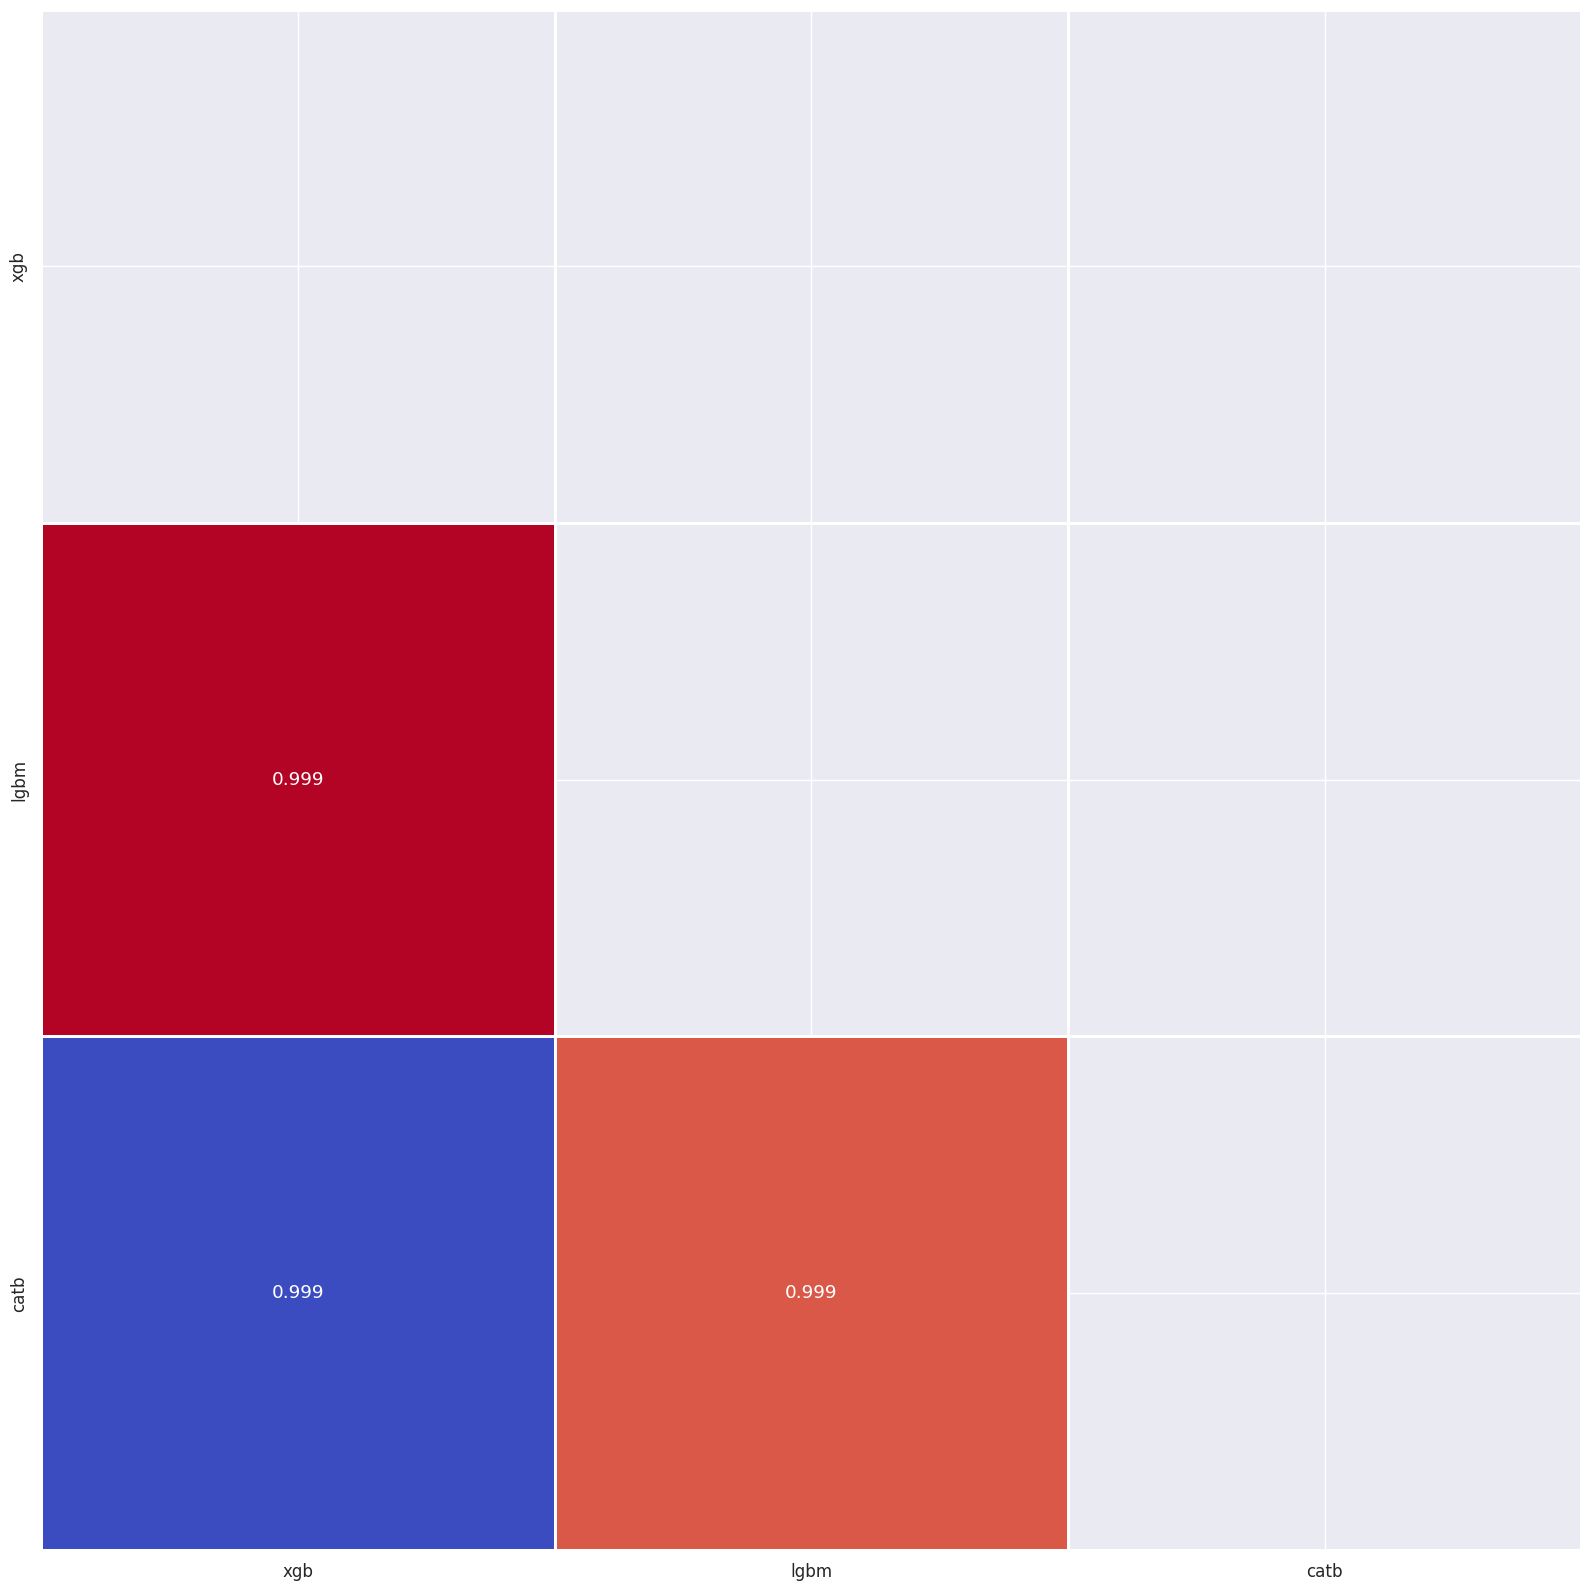

In [55]:
# Model diversity check

sns.set(font_scale=1.1)
correlation_train = oof_preds.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

## Voting & Stacking

### Voting

In [56]:
#voting hard & soft
def voting_ensemble(oof_preds, y, threshold=0.5, voting_type='soft'):
    if voting_type == 'soft':
        ensemble_preds = oof_preds.mean(axis=1)
        ensemble_class_preds = (ensemble_preds > threshold).astype(int)
        
    elif voting_type == 'hard':
        binary_preds = (oof_preds > threshold).astype(int)
        ensemble_class_preds = mode(binary_preds, axis=1)[0].flatten()
    
    mcc_score = matthews_corrcoef(y, ensemble_class_preds)
    
    return mcc_score

In [57]:
voting_ensemble(oof_preds, y, voting_type='soft')

0.9848303358534942

In [58]:
voting_ensemble(oof_preds, y, voting_type='hard')

0.9847637346196485

### Stacking

In [59]:
#parameters for meta model                                                                                                 
meta_model_params = {
    'C': 0.000237302749626327,
    'max_iter': 1297,
    'tol': 9.996751434702547e-05,
    'solver': 'saga',
    'penalty': 'l1'
}

meta_model = LogisticRegression(**meta_model_params, random_state=random_state)

In [60]:
%%time

#Deciding which models to include ensemble

min_features_to_select = 1

# Create a pipeline with preprocessor and RFECV
pipeline = Pipeline([
    
    ('Scaler', StandardScaler()),
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring=make_scorer(matthews_corrcoef),
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on oof_preds
pipeline.fit(oof_preds, y)

#CV score
print("Best CV score: ")
selected_models = np.array( oof_preds.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_models) - 1])


# Selected models after RFECV
print('Number of available models:', len(oof_preds.columns))
print('Number of selected models for ensemble:', len(selected_models))
print("Selected models:", selected_models)

Best CV score: 

0.9848391203164997

Number of available models: 3

Number of selected models for ensemble: 3

Selected models: ['xgb' 'lgbm' 'catb']

CPU times: user 33.5 s, sys: 740 ms, total: 34.3 s

Wall time: 1min 58s


In [61]:
meta_model = meta_model.fit(oof_preds[selected_models], y)

In [62]:
preds_test =  meta_model.predict(test_preds[selected_models])

In [63]:
preds_test = le.inverse_transform(preds_test)

# Submission

In [64]:
output = pd.DataFrame({'id': test_df.index,
                       'class': preds_test})

In [65]:
output.to_csv('submission_ensemble.csv', index=False)

In [66]:
output.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [67]:
#save oofs and test predictions for later usage
oof_preds.to_parquet('oof_predictions_v01.parquet', index=False)
test_preds.to_parquet('test_predictions_v01.parquet', index=False)